In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json
import tqdm
import matplotlib.ticker as ticker
sns.set()

In [2]:
import sys
sys.path.insert(0, '../')
from model.seq2seq import Seq2Seq, tf
from model.decoding_techniques import BeamSearchDecoder, GreedyDecoder, NucleusDecoder
from utils.processing_utils import *

# Loading data and spliting

In [3]:
data_path = '../processed_data'
mode = 'custom'
if mode=='w2v':
    with open(os.path.join(data_path,'w2v_embeddings_cornell.npy'), 'rb') as f:
        final_embeddings = np.load(f)

    with open(os.path.join(data_path,'missing_in_w2v_cornell.npy'), 'rb') as f:
        missing = np.load(f)
elif mode=='glove':
    with open(os.path.join(data_path,'glove_embeddings_cornell.npy'), 'rb') as f:
        final_embeddings = np.load(f)

    with open(os.path.join(data_path,'missing_in_glove_cornell.npy'), 'rb') as f:
        missing = np.load(f)
elif mode=='custom':
    with open(os.path.join(data_path,'glove_embeddings_trained_cornell.npy'), 'rb') as f:
        final_embeddings = np.load(f)

    with open(os.path.join(data_path,'missing_in_glove_trained_cornell.npy'), 'rb') as f:
        missing = np.load(f)
        
with open(os.path.join(data_path,'token_mapping_cornell.json'), 'r') as f:
    token_mapping = json.load(f)

with open(os.path.join(data_path,'data_cornell.npy'), 'rb') as f:
    data = np.load(f,allow_pickle=True)  

In [4]:
missing_idx = [token_mapping[i] for i in missing]

In [5]:
len(data)

82957

In [6]:
inverse_token_mapping = dict((v,k) for k,v in token_mapping.items())
pad_token = inverse_token_mapping[0]
start_token = inverse_token_mapping[1]
end_token = inverse_token_mapping[2]
unk_token = inverse_token_mapping[3]

In [7]:
pad_token, start_token, end_token,unk_token

('<pad>', '<start>', '<end>', '<unk>')

In [8]:
test = data[2]
[test[i:i+2] for i in range(0,len(test)-1,1)]

[['no no it is my fault we did not have a proper introduction', 'Cameron .'],
 ['Cameron .',
  'the thing is Cameron i am at the mercy of a particularly hideous breed of loser . my sister . i cannot date until she does .'],
 ['the thing is Cameron i am at the mercy of a particularly hideous breed of loser . my sister . i cannot date until she does .',
  'seems like she could get a date easy enough .']]

In [9]:
def slice_data(data):
    X, y = [], []
    for conversation in data:
        pairs = np.array([conversation[i:i+2] for i in range(0,len(conversation)-1,1)])
        X.extend(list(pairs[:,0]))
        y.extend(list(pairs[:,1]))
    return X, y

In [10]:
X, y = slice_data(data)

In [11]:
len(X), len(y)

(221068, 221068)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.15, shuffle=True)

In [13]:
len(X_train), len(X_test)

(187907, 33161)

In [14]:
def map_to_ids(x, mapping, end_token=None, start_token=None, padding_token=None, max_len=None, 
              return_len=False):
  if isinstance(x, str):
    x = x.split(' ')
  max_len = max_len if max_len else len(x)
  length = len(x)
  if start_token:
    x = [start_token] + x
  sent_ids = [mapping[word] for word in x[:max_len]]
  if max_len>len(x):
      if end_token:
        sent_ids.append(mapping[end_token])
      if padding_token:
        sent_ids += [mapping[padding_token]]*(max_len-len(sent_ids))
      if return_len:
          return sent_ids,length+1
      else:
          return sent_ids
  if end_token:
    sent_ids[-1] = mapping[end_token]
  if return_len:
      return sent_ids, max_len
  else:
      return sent_ids


In [15]:
max_len_tokens = 10

In [16]:
X_train_enc = np.array([map_to_ids(i, token_mapping, end_token, None, pad_token, max_len_tokens) for i in X_train])
X_test_enc = np.array([map_to_ids(i, token_mapping, end_token, None, pad_token, max_len_tokens) for i in X_test])
X_train_dec = np.array([map_to_ids(i, token_mapping, None, start_token, pad_token, max_len_tokens) for i in y_train])
X_test_dec = np.array([map_to_ids(i, token_mapping, None, start_token, pad_token, max_len_tokens) for i in y_test])
y_train, len_train = zip(*[map_to_ids(i, token_mapping, end_token, None, pad_token, max_len_tokens, return_len=True) for i in y_train])
y_test, len_test = zip(*[map_to_ids(i, token_mapping, end_token, None, pad_token, max_len_tokens, return_len=True) for i in y_test])
y_train, len_train, y_test, len_test  = np.array(y_train), np.array(len_train), np.array(y_test), np.array(len_test)

In [17]:
X_train_dec[0], y_train[0], len_train[0]

(array([    1, 21261, 29465,     8,     0,     0,     0,     0,     0,
            0]),
 array([21261, 29465,     8,     2,     0,     0,     0,     0,     0,
            0]),
 4)

# Building a model 

In [18]:
final_embeddings.shape

(30003, 100)

In [19]:
seq2seq = Seq2Seq(token_mapping, 
         pad_token=token_mapping[pad_token],
         end_token=token_mapping[end_token],
         start_token=token_mapping[start_token],
         max_len=max_len_tokens,
         embeddings=final_embeddings,
         embedding_prefix=mode,
         missing_tokens=np.array(missing_idx).astype(np.int32)
        )

# Training a model

In [20]:
train_data = tf.data.Dataset.from_tensor_slices((X_train_enc, X_train_dec, y_train, len_train))
val_data = tf.data.Dataset.from_tensor_slices((X_test_enc, X_test_dec, y_test, len_test))

In [21]:
batch_size = 256
num_epochs = 100
epochs_patience = 10

In [ ]:
seq2seq.fit(train_data,
            validation_dataset=val_data,
            steps_per_epoch=X_train_enc.shape[0]//batch_size,
            batch_size=batch_size,
            num_epochs=num_epochs,
            epochs_patience=epochs_patience,
            experiment_name='cornell')

  0%|          | 0/100 [00:00<?, ?it/s]

Dir models already exists


Epoch 0 train loss 6.2129 train perplexity 2498.6628


  1%|          | 1/100 [06:30<10:43:40, 390.10s/it]



Epoch 0 validation loss 5.6455 validation perplexity 285.1421




# Testing predictions and other helpful stuff

In [20]:
from utils.model_utils import plot_attention

In [21]:
def process(x, unk_token):
  res = []
  for i in x.split(' '):
    if token_mapping.get(i):
      res.append(i)
    elif token_mapping.get(i.lower()):
      res.append(i.lower())
    else:
      res.append(unk_token)
  return res

In [22]:
def give_answer(decoder, sentence, inverse_token_mapping, pad_unk=True, process_sentence=True, len_output=50,
               beam_size=3,
              top_p=0.95,
               beam_search=False,
               nucleus_sampling = False,
               show_attention=False):
      if process_sentence:
        cleaned_sentence = uncover_reduction(clean_bad_chars(sentence))
        unk_token = pad_token if pad_unk else "<unk>"
        processed_sentence = process(cleaned_sentence, unk_token)
        mapped_sentence = map_to_ids(processed_sentence, token_mapping, end_token, padding_token=pad_token, max_len=max_len_tokens)
      else:
        mapped_sentence = sentence
      if beam_search:
        prediction = decoder.decode(mapped_sentence, beam_size)
      elif nucleus_sampling:
        prediction = decoder.decode(mapped_sentence, len_output, top_p)
      else:
          prediction = decoder.decode(mapped_sentence, len_output, show_attention)
      if show_attention and not beam_search:
        prediction, attention = prediction
      answer = " ".join([inverse_token_mapping.get(i) for i in prediction]).capitalize()
      if show_attention and not beam_search:
            plot_attention(attention,sentence.split(' '), answer.split(' '))
      return answer

In [23]:
greedy_decoder = GreedyDecoder(decoder=seq2seq.decoder,
             encoder=seq2seq.encoder,
             max_len=max_len_tokens,
             start_token=token_mapping[start_token],
             end_token=token_mapping[end_token])

../utils/model_utils.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
../utils/model_utils.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


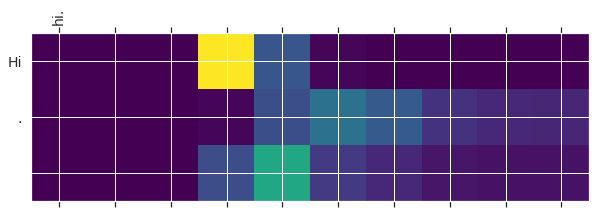

'Hi .'

In [24]:
give_answer(greedy_decoder, 'hi. ', inverse_token_mapping, show_attention=True)

In [25]:
beam_search_decoder = BeamSearchDecoder(decoder=seq2seq.decoder, 
                 encoder=seq2seq.encoder,
                 max_len=max_len_tokens,
                 start_token=token_mapping[start_token],
                 end_token=token_mapping[end_token])

In [26]:
give_answer(beam_search_decoder, 'hi ', inverse_token_mapping, show_attention=False,
           beam_search=True)

'Hello .'

In [27]:
nucleus_decoder = NucleusDecoder(decoder=seq2seq.decoder, 
                 encoder=seq2seq.encoder,
                 max_len=max_len_tokens,
                 start_token=token_mapping[start_token],
                 end_token=token_mapping[end_token])

In [54]:
give_answer(nucleus_decoder, 'hi', inverse_token_mapping, nucleus_sampling=True, top_p=0.75)

'Tell the bill back back home with here .'

# Dialogue generation and question answering

../utils/model_utils.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
../utils/model_utils.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


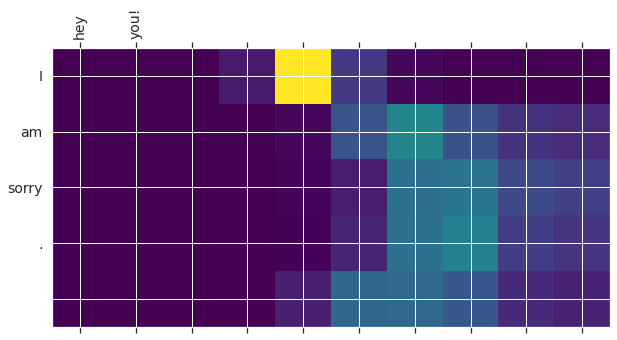

------------------------------
Test replica : hey you!
Bot greedy answer : I am sorry .
Bot beam search answer : What ?
Bot nucleus answr : Lets the goddamn watch up . it is coming
------------------------------


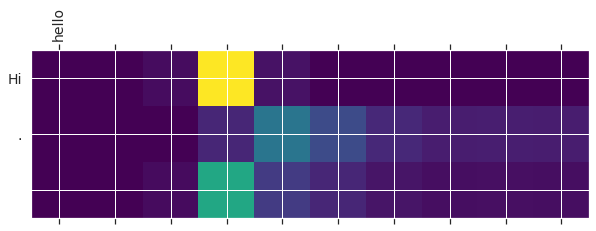

------------------------------
Test replica : hello
Bot greedy answer : Hi .
Bot beam search answer : Hello .
Bot nucleus answr : Ok .
------------------------------


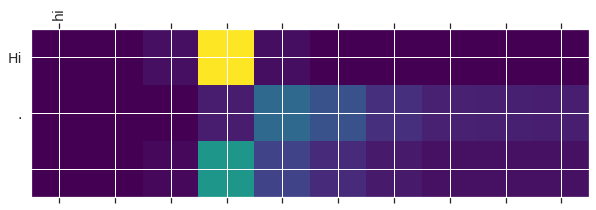

------------------------------
Test replica : hi
Bot greedy answer : Hi .
Bot beam search answer : Hello .
Bot nucleus answr : Why are you saying to stay ?
------------------------------


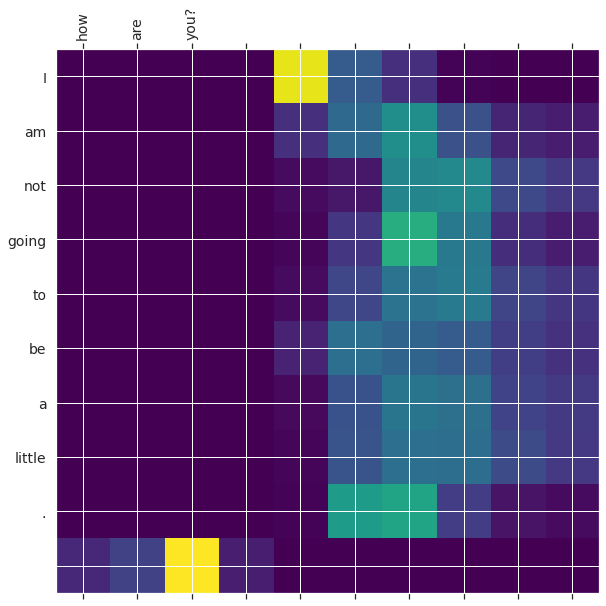

------------------------------
Test replica : how are you?
Bot greedy answer : I am not going to be a little .
Bot beam search answer : Fine .
Bot nucleus answr : An my finger like on and how about two
------------------------------


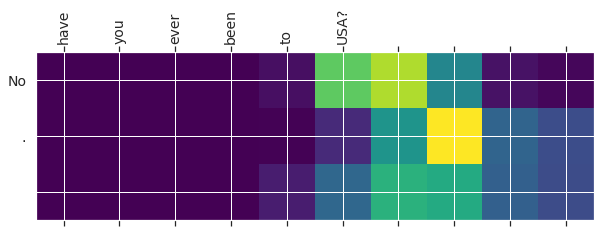

------------------------------
Test replica : have you ever been to USA?
Bot greedy answer : No .
Bot beam search answer : Yes .
Bot nucleus answr : A u six ! i want this will let
------------------------------


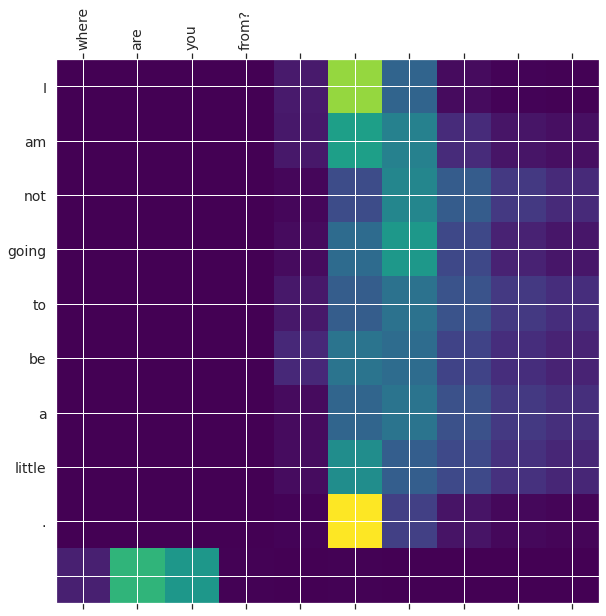

------------------------------
Test replica : where are you from?
Bot greedy answer : I am not going to be a little .
Bot beam search answer : I do not know .
Bot nucleus answr : Over we get around a lie down !
------------------------------


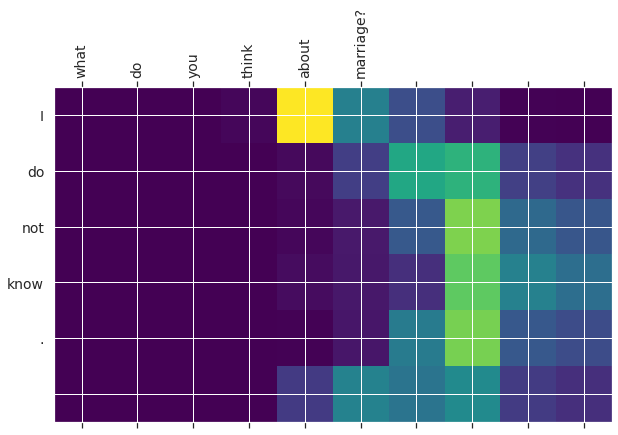

------------------------------
Test replica : what do you think about marriage?
Bot greedy answer : I do not know .
Bot beam search answer : I do not know .
Bot nucleus answr : A wonderful case looks so up of like twigs
------------------------------


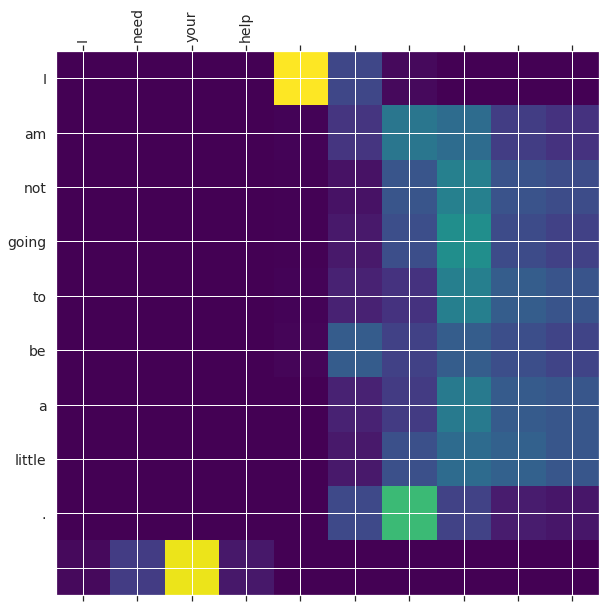

------------------------------
Test replica : I need your help
Bot greedy answer : I am not going to be a little .
Bot beam search answer : No .
Bot nucleus answr : Right okay okay ! i am i really fucking
------------------------------


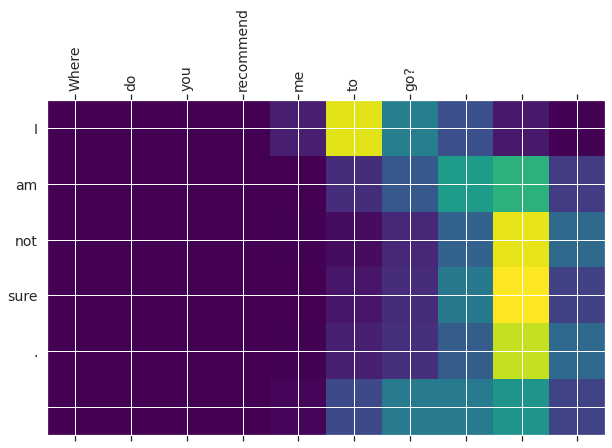

------------------------------
Test replica : Where do you recommend me to go?
Bot greedy answer : I am not sure .
Bot beam search answer : Yes .
Bot nucleus answr : When are we supposed
------------------------------


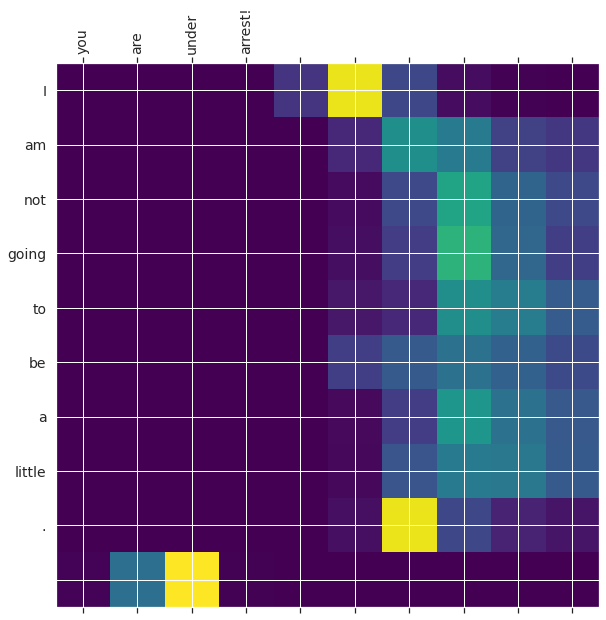

------------------------------
Test replica : you are under arrest!
Bot greedy answer : I am not going to be a little .
Bot beam search answer : I am sorry .
Bot nucleus answr : Thank you man ! this place what ?
------------------------------


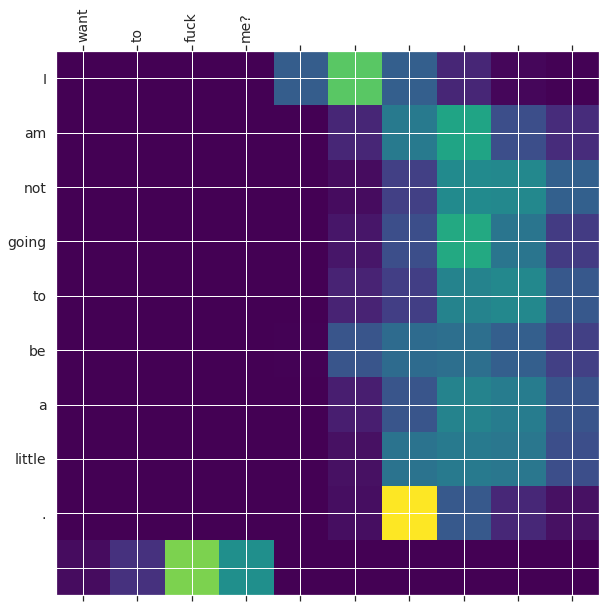

------------------------------
Test replica : want to fuck me?
Bot greedy answer : I am not going to be a little .
Bot beam search answer : No .
Bot nucleus answr : How about i come on i get .
------------------------------


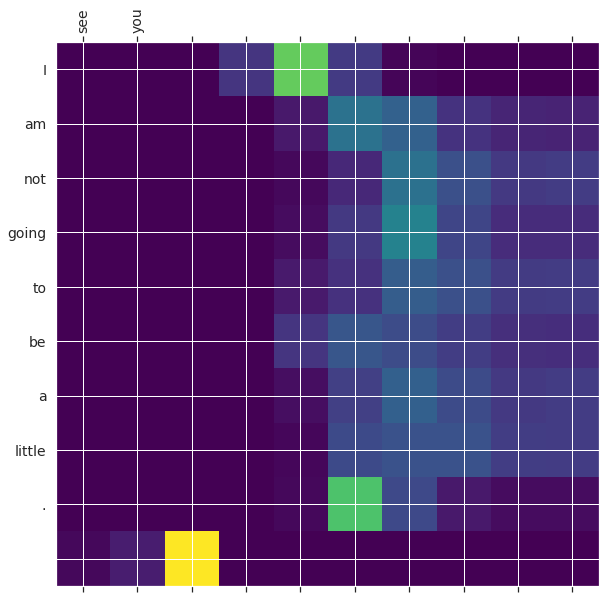

------------------------------
Test replica : see you
Bot greedy answer : I am not going to be a little .
Bot beam search answer : No .
Bot nucleus answr : My pleasure agent does that name if i knew
------------------------------


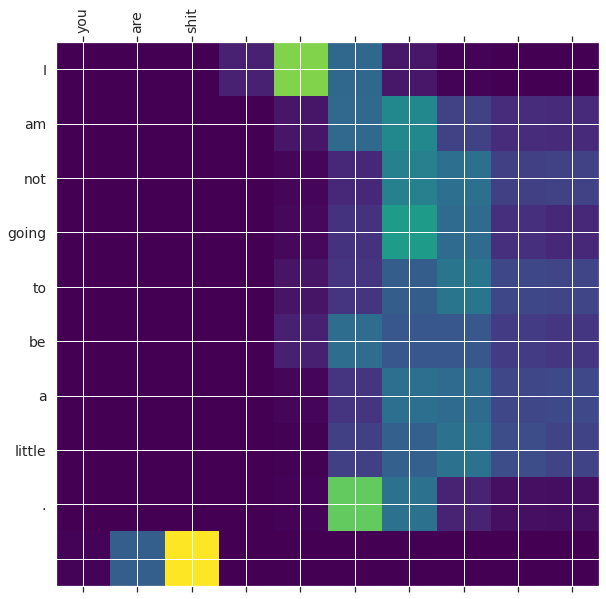

------------------------------
Test replica : you are shit
Bot greedy answer : I am not going to be a little .
Bot beam search answer : No .
Bot nucleus answr : I think so
------------------------------


In [56]:
replicas = ['hey you!',
            'hello',
            'hi',
            'how are you?',
            'have you ever been to USA?',
            'where are you from?',
            'what do you think about marriage?',
             'I need your help',
           'Where do you recommend me to go?',
           'you are under arrest!',
           'want to fuck me?',
           'see you',
           'you are shit']
for i in replicas:
    greedy_answer = give_answer(greedy_decoder, i, inverse_token_mapping, show_attention=True)
    beam_search_answer = give_answer(beam_search_decoder, i, inverse_token_mapping,
           beam_search=True,
           beam_size=3)
    nucleus_answer = give_answer(nucleus_decoder, i, inverse_token_mapping, 
                                 nucleus_sampling=True, 
                                 top_p=0.75)
    print(30*'-')
    print('Test replica : {}'.format(i))
    print('Bot greedy answer : {}'.format(greedy_answer))
    print('Bot beam search answer : {}'.format(beam_search_answer))
    print('Bot nucleus answr : {}'.format(nucleus_answer))
    print(30*'-')


# Gabberish dialogue

In [59]:
n_replicas = 1000
count = 0
replica = str(input()).strip()
while count<n_replicas:
    replica = give_answer(nucleus_decoder, replica, inverse_token_mapping, 
                                 nucleus_sampling=True, 
                                 top_p=0.65)
    print('\n--- {}'.format(replica))
    count+=1

hello

--- . mr

--- My baby died you got the lunch ?

--- Oh it is your duty ?

--- He says she has never .

--- Oh my name .

--- Hi you will bet you that dad and take

--- That

--- Some of pep it

--- Well a lawyer ?

--- What did he see ?

--- Not ! you killed him !

--- You cannot want me that you have told me

--- That

--- His side last .

--- For chrissakes sake to a bell and while when

--- Maybe if you think you are such out to

--- That

--- Our interest must not an enormous power !

--- But he is an ax wife lives u havoc

--- Is it a rifle in 

--- Why would you keep them a wedding

--- I have always as so about that we need

--- Okay !

--- So . i cannot .

--- He was working at first in the ocean as

--- And it is going to bring a bullet all

--- It

--- Hi go ?

--- It

--- Tell her last of here i mean you would

--- If i want to leave her name

--- That

--- Shit that is just one of the edge of

--- Look this will not be enough ?

--- But if i think i am so this is

--


--- How do

--- Where ?

--- Get me too much that !

--- Are

--- No no not what we need more thing .

--- Wait we go home !

--- Forget !

--- Can you go you could . we get married

--- If i am the key you want me and

--- Thank

--- Okay if i want to sleep on

--- Come on where i i need your best are

--- Come

--- Please it .

--- You just relax yourself up for ?

--- Look that it would not be to start it

--- The situation will have no shit of here .

--- Where are you kidding

--- We have the strongest should go out and .

--- Why would you get you out there

--- Uh huh .

--- Good . you think you can wait that if

--- How is that supposed to make ?

--- But we cannot take your truck .

--- Yeah ! it is so fucking so hard to

--- Just that out .

--- Yeah well they are they open around up to

--- Did you call her into a world after and

--- Did not she take him that story what we

--- What about this is not i do not make

--- Yeah ! it is easy .

--- He said i got an interesting 


--- How would you make any poe

--- Why are you saying a lawyer

--- That

--- Jesus you do

--- Why are you trying

--- But we do

--- Yeah that

--- He must have been alive before before had we

--- Oh that

--- Did you go here for you ?

--- Come on here .

--- Good .

--- Uh huh .

--- You have never known .

--- No way i will never a professional you to

--- Then do not even anyone about me !

--- No .

--- Have to meet .

--- Get outta !

--- They are all they you take and fire on

--- You mean about it ?

--- No you cannot be careful .

--- I will just see .

--- No !

--- Then .

--- Lets . go . you did not want

--- Oh yes .

--- Okay do

--- How would

--- The we found there and how you got something

--- That

--- When ?

--- Look . a right . i have to give

--- That

--- Mr

--- Ah what ?

--- So that

--- He got me i

--- They just make your opinion .

--- Well lets do not just going anywhere ?

--- Oh you can use the pot i want a

--- So far a year girl about it was is




--- Oh god i will give it a deep this

--- But you want to help you what happened i

--- That

--- Why not you learn ?

--- They want us out and say something it was

--- Maybe it was me home to ask him .

--- The situation ?

--- I want you to die .

--- Do not talk about me .

--- That

--- All of what ?

--- Yeah we can put you in new york ?

--- How much would you be better to kill you

--- Yeah . well how are

--- Right ! we do

--- How long you just just doing .

--- They do

--- Get some game door . i was no reason

--- I think you would know if you had one

--- That

--- And it

--- . the entire side ?

--- Do not take me too late .

--- Yes ?

--- Look the fourth hotel on my wife who made

--- Then ?

--- Ah yes .

--- Are

--- Now why not you wanna to be listening ?

--- What do

--- Look what you do with him ?

--- If you had this job when it all day

--- Sure you were around .

--- It is only important nice .

--- Yes ?

--- <unk> .

--- The swamp man is he turned a head f

# Interactive usage

In [31]:
inp = ''
while True:
    inp = str(input()).strip()
    if inp=='exit':
        break
    greedy_answer = give_answer(greedy_decoder, inp, inverse_token_mapping, show_attention=False)
    beam_search_answer = give_answer(beam_search_decoder, inp, inverse_token_mapping,
           beam_search=True,
           beam_size=7)
    print(30*'-')
    print('Replica : {}'.format(inp))
    print('Beam answer : {}'.format(beam_search_answer))
    print('Greedy answer : {}'.format(greedy_answer))
    print(30*'-')

hello, Jake
------------------------------
Replica : hello, Jake
Beam answer : Hi ?
Greedy answer : Hi .
------------------------------
where are we?
------------------------------
Replica : where are we?
Beam answer : I do not know .
Greedy answer : I am going to be a little .
------------------------------
hell fuck
------------------------------
Replica : hell fuck
Beam answer : What ?
Greedy answer : You are not going to be a little .
------------------------------
excuse me?
------------------------------
Replica : excuse me?
Beam answer : That is right .
Greedy answer : I am not going to be a little .
------------------------------
kill yourself
------------------------------
Replica : kill yourself
Beam answer : What ?
Greedy answer : I am not going to be a little .
------------------------------
you are dump
------------------------------
Replica : you are dump
Beam answer : I do not know .
Greedy answer : I am not going to be a little .
------------------------------
fucking s

KeyboardInterrupt: Interrupted by user